# Optimization + Simulation: The Two-Step Process

This notebook demonstrates how optimization and simulation work together to find robust recommendations.

Understanding this is critical because:
- **Optimization** finds a good recommendation under your assumptions
- **Simulation** tests that recommendation under uncertainty
- Together, they help you find recommendations that work in practice, not just in theory
- This two-step process prevents fragile solutions


## Key Concepts

**Step 1: Optimize**
- Build model with best estimates for uncertain inputs
- Find optimal recommendation
- This gives you a starting point

**Step 2: Simulate**
- Take the optimal recommendation
- Test it under many scenarios with varying inputs
- See if it's robust or fragile

**Critical insight**: Optimal under perfect conditions ≠ best choice in uncertain world. Simulation reveals this before implementation.


## Scenario: Production Planning

You need to decide how much to produce. You optimize first, then simulate to test robustness.


## Step 1: Install Required Packages (Colab)


In [1]:
# Install required packages (if needed in Colab)
%pip install numpy matplotlib pandas pulp -q



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


## Step 2: Import Libraries


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pulp import LpMaximize, LpProblem, LpVariable, value

np.random.seed(42)


## Step 3: Step 1 - Optimize

Build optimization model with best estimates:


In [3]:
# STEP 1: OPTIMIZE
# Use best estimates for uncertain inputs

# Best estimates (assumed to be certain)
demand_estimate = 1000
profit_per_unit = 50
capacity = 1200

# Build optimization model
model = LpProblem("Production", LpMaximize)
produce = LpVariable("produce", lowBound=0, upBound=capacity, cat='Continuous')

# Objective: maximize profit
model += profit_per_unit * produce, "Profit"

# Constraint: can't produce more than demand
model += produce <= demand_estimate, "Demand"

# Solve
model.solve()
optimal_production = value(produce)
optimal_profit = value(model.objective)

print("STEP 1: OPTIMIZATION RESULT")
print(f"  Optimal production: {optimal_production:.0f} units")
print(f"  Expected profit: ${optimal_profit:,.0f}")
print(f"  (Based on assumption: demand = {demand_estimate} units)")
print(f"\n✅ Optimization says: 'This is optimal!'")
print(f"⚠️  But what if demand isn't exactly {demand_estimate}?")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/sturner/.pyenv/versions/3.12.7/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/2b154b1e42fb4c5fbd1bf48f77a3e24b-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/0v/80zxmry158l85b2sy7ywwj5w0000gn/T/2b154b1e42fb4c5fbd1bf48f77a3e24b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 6 COLUMNS
At line 9 RHS
At line 11 BOUNDS
At line 13 ENDATA
Problem MODEL has 1 rows, 1 columns and 1 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 0 (-1) rows, 0 (-1) columns and 0 (-1) elements
Empty problem - 0 rows, 0 columns and 0 elements
Optimal - objective value 50000
After Postsolve, objective 50000, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 50000 - 0 iterations time 0.002, Presolve 0.00
Option for p

## Step 4: Step 2 - Simulate

Test the optimal recommendation under uncertainty:


In [4]:
# STEP 2: SIMULATE
# Test the optimal recommendation under uncertainty

def calculate_actual_profit(production, actual_demand):
    """Calculate profit given production and actual demand"""
    units_sold = min(production, actual_demand)
    unsold_units = max(0, production - actual_demand)
    profit = units_sold * profit_per_unit - unsold_units * 20  # $20 loss per unsold unit
    return profit

# Run simulation: demand varies
num_scenarios = 1000
demand_scenarios = np.random.normal(loc=1000, scale=150, size=num_scenarios)
demand_scenarios = np.clip(demand_scenarios, 700, 1300)

# Test the optimal production level under varying demand
profits = [calculate_actual_profit(optimal_production, d) for d in demand_scenarios]
profits = np.array(profits)

print("STEP 2: SIMULATION RESULTS")
print(f"  Testing optimal production ({optimal_production:.0f} units) under uncertainty")
print(f"  Best case profit: ${profits.max():,.0f}")
print(f"  Worst case profit: ${profits.min():,.0f}")
print(f"  Average profit: ${profits.mean():,.2f}")
print(f"  Range: ${profits.min():,.0f} to ${profits.max():,.0f}")
print(f"\n📊 The optimal solution has significant variability!")
print(f"   Worst case: ${profits.min():,.0f} (could lose money!)")


STEP 2: SIMULATION RESULTS
  Testing optimal production (1000 units) under uncertainty
  Best case profit: $50,000
  Worst case profit: $29,000
  Average profit: $46,064.87
  Range: $29,000 to $50,000

📊 The optimal solution has significant variability!
   Worst case: $29,000 (could lose money!)


## Step 5: Visualize the Two-Step Process


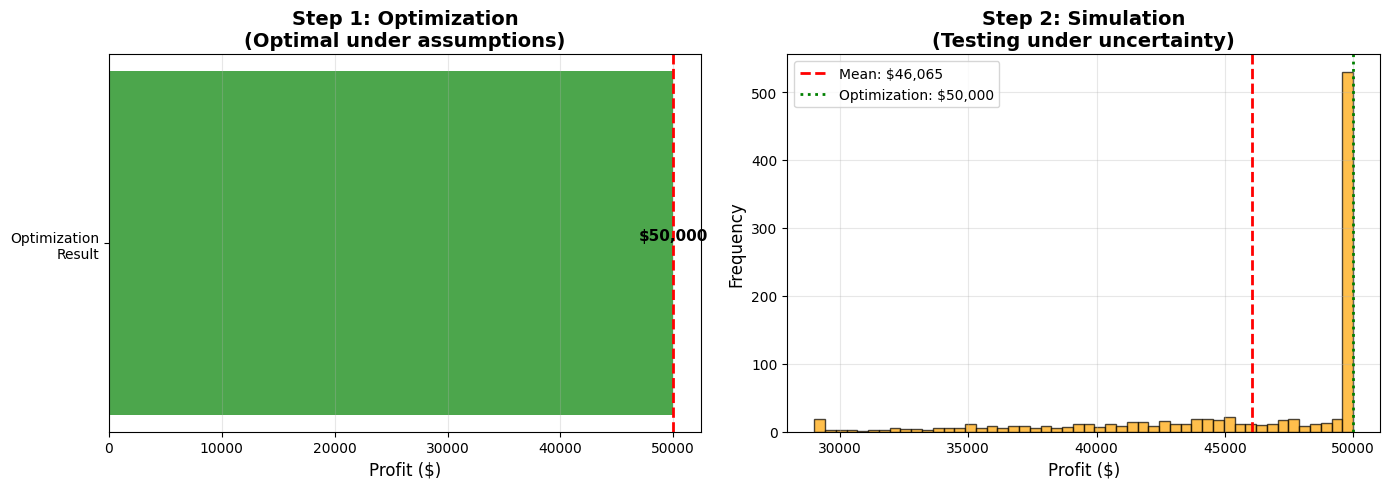


🔍 KEY INSIGHT:
   Optimization: One number (${optimal_profit:,.0f})
   Simulation: Range (${profits.min():,.0f} to ${profits.max():,.0f})
   The optimal solution is FRAGILE - it breaks when demand varies!


In [5]:
# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Optimization result
ax1.barh(['Optimization\nResult'], [optimal_profit], color='green', alpha=0.7)
ax1.axvline(optimal_profit, color='red', linestyle='--', linewidth=2)
ax1.set_xlabel('Profit ($)', fontsize=12)
ax1.set_title('Step 1: Optimization\n(Optimal under assumptions)', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
ax1.text(optimal_profit, 0, f'${optimal_profit:,.0f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Right: Simulation results
ax2.hist(profits, bins=50, color='orange', alpha=0.7, edgecolor='black')
ax2.axvline(profits.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: ${profits.mean():,.0f}')
ax2.axvline(optimal_profit, color='green', linestyle=':', linewidth=2, label=f'Optimization: ${optimal_profit:,.0f}')
ax2.set_xlabel('Profit ($)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Step 2: Simulation\n(Testing under uncertainty)', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🔍 KEY INSIGHT:")
print("   Optimization: One number (${optimal_profit:,.0f})")
print("   Simulation: Range (${profits.min():,.0f} to ${profits.max():,.0f})")
print("   The optimal solution is FRAGILE - it breaks when demand varies!")


## Key Takeaways

1. **Optimize first**: Get a good starting point using your best estimates.

2. **Then simulate**: Test that recommendation under uncertainty to see if it's robust.

3. **Two-step process**: Optimization gives you a recommendation; simulation tells you if it will work in practice.

4. **Iterate if needed**: If simulation shows the solution is fragile, adjust and optimize again.

5. **Robustness matters**: A slightly less optimal but more robust solution is often better than an optimal but fragile one.

**Next steps**: In the next notebook, we'll compare robust vs fragile solutions in detail.
